In [1]:
import torch
import torch.nn
import torch.utils
import torch.utils.data
import fine_tune
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [2]:
TASK = 'qnli'
TEACHER_EXP = 'teacher_base'
TMODEL = 'bert'
TCKPT = 8000
STUDENT_EXP = 'MSE_init_from_pre_trained'
SMODEL = 'bert'
SCKPT = 12000
DATASET = 'dev'
SDEVICE = 1
TDEVICE = 1
BATCH_SIZE = 32

In [3]:
teacher_config = fine_tune.config.TeacherConfig.load(
    experiment=TEACHER_EXP,
    model=TMODEL,
    task=TASK
)
teacher_config.device_id = TDEVICE
teacher_config.dataset = DATASET
print(teacher_config)


+---------------------------------------+
| configuration     | value             |
+---------------------------------------+
| accum_step        | 2                 |
| amp               | 0                 |
| batch_size        | 32                |
| beta1             | 0.9               |
| beta2             | 0.999             |
| ckpt_step         | 1000              |
| dataset           | dev               |
| device_id         | 1                 |
| dropout           | 0.1               |
| eps               | 1e-08             |
| experiment        | teacher_base      |
| log_step          | 500               |
| lr                | 3e-05             |
| max_norm          | 1.0               |
| max_seq_len       | 128               |
| model             | bert              |
| num_class         | 2                 |
| ptrain_ver        | bert-base-uncased |
| seed              | 42                |
| task              | qnli              |
| total_step        | 9822       

In [4]:
fine_tune.util.set_seed_by_config(teacher_config)

In [5]:
student_config = fine_tune.config.StudentConfig.load(
    experiment=STUDENT_EXP,
    model=SMODEL,
    task=TASK
)
student_config.device_id = SDEVICE
student_config.dataset = DATASET
print(student_config)


+-------------------------------------------------------+
| configuration             | value                     |
+-------------------------------------------------------+
| accum_step                | 1                         |
| amp                       | 0                         |
| batch_size                | 32                        |
| beta1                     | 0.9                       |
| beta2                     | 0.999                     |
| ckpt_step                 | 1000                      |
| d_emb                     | 128                       |
| d_ff                      | 3072                      |
| d_model                   | 768                       |
| dataset                   | dev                       |
| device_id                 | 1                         |
| dropout                   | 0.1                       |
| eps                       | 1e-08                     |
| experiment                | MSE_init_from_pre_trained |
| log_step   

In [6]:
dataset = fine_tune.util.load_dataset_by_config(
    config=teacher_config
)

2021/05/05 20:33:46 - INFO - fine_tune.task -   Start loading task QNLI dataset dev.
Loading QNLI dev: 5463it [00:00, 312087.75it/s]
2021/05/05 20:33:46 - INFO - fine_tune.task -   Number of samples: 5463
2021/05/05 20:33:46 - INFO - fine_tune.task -   Finish loading task QNLI dataset dev.


In [7]:
teacher_tknr = fine_tune.util.load_teacher_tokenizer_by_config(
    config=teacher_config
)
student_tknr = fine_tune.util.load_student_tokenizer_by_config(
    config=student_config
)

In [8]:
TEACHER_EXP_NAME = fine_tune.config.BaseConfig.experiment_name(
    experiment=teacher_config.experiment,
    model=teacher_config.model,
    task=teacher_config.task
)
TEACHER_EXP_DIR = os.path.join(
    fine_tune.path.FINE_TUNE_EXPERIMENT,
    TEACHER_EXP_NAME
)
print(TEACHER_EXP_DIR)

/home/kychen/Desktop/BERT-gang/data/fine_tune_experiment/teacher_base_bert_qnli


In [9]:
teacher_model = fine_tune.util.load_teacher_model_by_config(
    config=teacher_config
)
teacher_model.load_state_dict(
    torch.load(
        os.path.join(TEACHER_EXP_DIR, f'model-{TCKPT}.pt'),
        map_location=teacher_config.device
    )
)

<All keys matched successfully>

In [10]:
STUDENT_EXP_NAME = fine_tune.config.BaseConfig.experiment_name(
    experiment=student_config.experiment,
    model=student_config.model,
    task=student_config.task
)
STUDENT_EXP_DIR = os.path.join(
    fine_tune.path.FINE_TUNE_EXPERIMENT,
    STUDENT_EXP_NAME
)
print(STUDENT_EXP_DIR)

/home/kychen/Desktop/BERT-gang/data/fine_tune_experiment/MSE_init_from_pre_trained_bert_qnli


In [11]:
student_model = fine_tune.util.load_student_model_by_config(
    config=student_config,
    tokenizer=student_tknr
)
student_model.load_state_dict(
    torch.load(
        os.path.join(STUDENT_EXP_DIR, f'model-{SCKPT}.pt'),
        map_location=student_config.device
    )
)

2021/05/05 20:33:56 - INFO - fine_tune.model.student_bert -   Load model state dict from pre-trained model
2021/05/05 20:33:56 - INFO - fine_tune.model.student_bert -   Finish initialization from pre-trained model


<All keys matched successfully>

In [12]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    collate_fn=dataset.create_collate_fn(),
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [13]:
student_model.eval()
teacher_model.eval()

y_ground = []
y_teacher = []
y_student = []

with torch.no_grad():
    for text, text_pair, label in tqdm(dataloader):
        teacher_encode = teacher_tknr(
            text=text,
            text_pair=text_pair,
            padding='max_length',
            max_length=teacher_config.max_seq_len,
            return_tensors='pt',
            truncation=True
        )
        teacher_input_ids = teacher_encode['input_ids']
        teacher_token_type_ids = teacher_encode['token_type_ids']
        teacher_attention_mask = teacher_encode['attention_mask']

        student_encode = student_tknr(
            text=text,
            text_pair=text_pair,
            padding='max_length',
            max_length=student_config.max_seq_len,
            return_tensors='pt',
            truncation=True
        )
        student_input_ids = student_encode['input_ids']
        student_token_type_ids = student_encode['token_type_ids']
        student_attention_mask = student_encode['attention_mask']

        t_pred_label = teacher_model.predict(
            input_ids = teacher_input_ids.to(teacher_config.device),
            token_type_ids = teacher_token_type_ids.to(teacher_config.device),
            attention_mask = teacher_attention_mask.to(teacher_config.device)
        ).argmax(dim=-1).to('cpu')

        s_pred_label = student_model.predict(
            input_ids = student_input_ids.to(student_config.device),
            token_type_ids = student_token_type_ids.to(student_config.device),
            attention_mask = student_attention_mask.to(student_config.device)
        ).argmax(dim=-1).to('cpu')

        y_ground.extend(label)
        y_teacher.extend(t_pred_label.tolist())
        y_student.extend(s_pred_label.tolist())




    


100%|██████████| 171/171 [00:33<00:00,  5.14it/s]


## Confusion matrix of teacher and student outputs

In [14]:
cm = confusion_matrix(y_teacher, y_student)

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

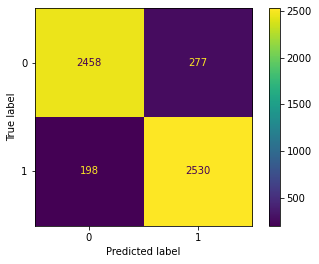

In [16]:
disp.plot(values_format='d')

## Confusion matrix of teacher and ground truth

In [17]:
cm2 = confusion_matrix(y_ground, y_teacher)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)

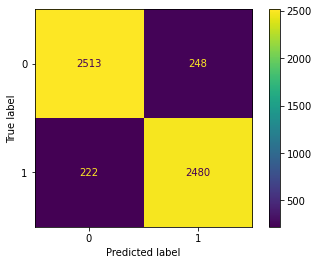

In [18]:
disp2.plot(values_format='d')

## Confusion matrix of student and ground truth

In [19]:
cm3 = confusion_matrix(y_ground, y_student)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3)

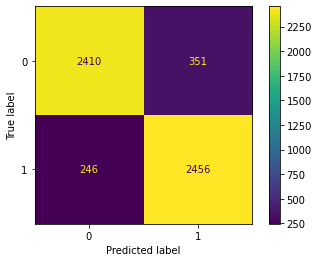

In [20]:
disp3.plot(values_format='d')

In [21]:
print(y_ground.count(0))
print(y_teacher.count(0))
print(y_student.count(0))

2761
2735
2656


In [22]:
print(y_ground.count(1))
print(y_teacher.count(1))
print(y_student.count(1))

2702
2728
2807


In [23]:
t_acc = accuracy_score(y_ground, y_teacher)
print(t_acc)

0.9139666849716274


In [24]:
s_acc = accuracy_score(y_ground, y_student)
print(s_acc)

0.8907193849533224


In [25]:
len(dataset) * (t_acc - s_acc)

127.00000000000018